# TDE Final de Econometria I

## Nome: Júlio Cristóvão Balena

## Procedimento de Pesquisa:

Estudar amostra que compõe informações de uma Assessoria da XP em relação a reuniões e captação

# STEP 1: Abrir o arquivo e definir subconjuntos.

As variáveis selecionadas e/ou construídas são:

'done_meetings': Reuniões feitas em M+0

'done_meetings+1_month': Reuniões feitas em M-1

'done_meetings+2_month': Reuniões feitas em M-2

'is_male': Variável dummy para representar se a amostra foi de um Assessor do gênero Masculino (1)

'client_count': Número de clientes em carteira no final do mês

'wallet_equity': Equity da carteira no final do mês

'average_ticket': Ticket Médio

'supernova': Variável dummy para representar se a carteira tem Menos de 80 clientes (1)

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load the data from .dta file
file_path = 'CdV_6_MONTHS.ods'
df = pd.read_excel('CdV_6_MONTHS.ods', engine='odf', sheet_name='Sheet1')

# New columns:
df['average_ticket'] = df['wallet_equity'] / df['client_count']
df['supernova'] = df['client_count'].apply(lambda x: 1 if x <= 80 else 0)


# Convert 'month_date' to datetime format
df['month_date'] = pd.to_datetime(df['month_date'], format='%Y-%m')
# Sort the data by 'employee_name' and 'month_date'
df = df.sort_values(by=['employee_name', 'month_date'])
# Create a new column with delayed values
df['done_meetings+1_month'] = df.groupby('employee_name')['done_meetings'].shift(-1)
df['done_meetings+2_month'] = df.groupby('employee_name')['done_meetings'].shift(-2)

# Define the dependent variable and the independent variables
y_subset = ['cap_value']

# Subset Option 1:
#x_subset = ['done_meetings', 'is_male', 'client_count', 'wallet_equity', 'average_ticket', 'supernova', 'done_meetings+1_month', 'done_meetings+2_month'] 

# Subset Option 2:
#x_subset = ['done_meetings', 'is_male', 'client_count', 'wallet_equity', 'supernova', 'done_meetings+1_month', 'done_meetings+2_month'] 

# Subset Option 3:
#x_subset = ['done_meetings', 'is_male', 'client_count', 'average_ticket', 'supernova', 'done_meetings+1_month'] 

# Subset Option 4:
x_subset = ['done_meetings', 'is_male', 'average_ticket', 'supernova', 'done_meetings+1_month']

# Create a list of all columns to check for NaNs
subset_check = y_subset + x_subset

# Drop rows where any of the specified columns have NaN values
df_filtered = df.dropna(subset=subset_check)

# Redefine y and X with the filtered data
y_filtered = df_filtered[y_subset]
X_filtered = df_filtered[x_subset]


# STEP 2: Testar para Multicolinearidade

Foram testados vários subsets de variáveis exógenas. Para todas as combinações foi encontrado apenas alta correlação no par:

'wallet_equity' & 'average_ticket'

Optei por remover 'wallet_equity'

In [6]:
import numpy as np

#Print X subset correlation
correlation_matrix = df[x_subset].corr()

# Create a mask to select the upper triangle of the correlation matrix
mask = (correlation_matrix.where(~np.tril(np.ones(correlation_matrix.shape)).astype(bool))).stack()

# Filter correlations greater than 0.80
high_correlations = mask[mask > 0.80]

high_correlations

Series([], dtype: float64)

# STEP 3: Fazer o modelo para OLS (MQO)

In [7]:
# Add a constant to the predictors for the intercept
X_filtered = sm.add_constant(X_filtered)

# Fit the linear regression model
model = sm.OLS(y_filtered, X_filtered).fit()

# Display a summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              cap_value   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.178
Method:                 Least Squares   F-statistic:                     4.066
Date:                Thu, 11 Jul 2024   Prob (F-statistic):            0.00281
Time:                        19:42:22   Log-Likelihood:                -1127.5
No. Observations:                  72   AIC:                             2267.
Df Residuals:                      66   BIC:                             2281.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -1.273e+

# STEP 4: Testar para Heterocedasticidade

- Observar variância dos erros
- Teste de Breusch-Pagan

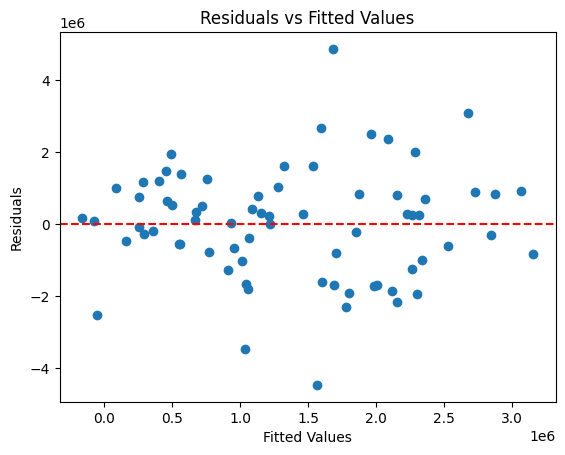

In [8]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Assuming you have a fitted model named `model`
residuals = model.resid
fitted = model.fittedvalues

plt.scatter(fitted, residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values')
plt.axhline(0, color='red', linestyle='--')
plt.show()


In [111]:
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.diagnostic import het_white

# Perform the Breusch-Pagan test
bp_test = het_breuschpagan(model.resid, model.model.exog)

# bp_test returns (Lagrange multiplier statistic, p-value, f-value, f p-value)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
bp_results = dict(zip(labels, bp_test))

print(bp_results)

{'Lagrange multiplier statistic': 14.765291184109843, 'p-value': 0.005213613861263528, 'f-value': 4.4882073765044765, 'f p-value': 0.0032854295827516398}


# STEP 5: Transformação Log-Log

- Teste extra utilizando modelo robusto a Heterocedasticidade (HC3)

In [9]:
# Create log-transformed columns for all variables with a small constant added
small_constant = 1e-6
log_vars = y_subset + x_subset
for var in log_vars:
    df[f'log_{var}'] = np.log(df[var] + small_constant)

# Define the log-transformed dependent variable and the independent variables
log_y_subset = [f'log_{var}' for var in y_subset]
log_x_subset = [f'log_{var}' for var in x_subset]

# Create a list of all columns to check for NaNs
log_subset_check = log_y_subset + log_x_subset

# Drop rows where any of the specified columns have NaN values
df_filtered = df.dropna(subset=log_subset_check)

# Redefine y and X with the log-transformed columns
y_filtered = df_filtered[log_y_subset]
X_filtered = df_filtered[log_x_subset]

# Add a constant to the predictors for the intercept
X_filtered = sm.add_constant(X_filtered)

# Fit the linear regression model
model = sm.OLS(y_filtered, X_filtered).fit()

# Display a summary of the regression results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          log_cap_value   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     5.340
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           0.000465
Time:                        19:50:37   Log-Likelihood:                -127.55
No. Observations:                  60   AIC:                             267.1
Df Residuals:                      54   BIC:                             279.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

/home/julio/Documents/econometrics-1/.venv/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [10]:
import statsmodels.api as sm

# Assuming y_filtered and X_filtered are already defined as in the previous example
model_robust = sm.OLS(y_filtered, X_filtered).fit(cov_type='HC3')
print(model_robust.summary())


                            OLS Regression Results                            
Dep. Variable:          log_cap_value   R-squared:                       0.331
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     3.723
Date:                Thu, 11 Jul 2024   Prob (F-statistic):            0.00573
Time:                        19:51:04   Log-Likelihood:                -127.55
No. Observations:                  60   AIC:                             267.1
Df Residuals:                      54   BIC:                             279.7
Df Model:                           5                                         
Covariance Type:                  HC3                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

# Conclusão

Para todos os subset testados (escolhido o subset 4 em log-log), o modelo apresentou um R² ajustado de 33%. Com base na análise, podemos concluir que a variável 'done_meetings+1', que representa a quantidade de reuniões feitas no mês anterior, é estatisticamente significativa. No entanto, o conceito de "Supernova" não demonstrou significância estatística dentro da amostra e do modelo utilizados. Outras variáveis exógenas também não apresentaram relevância estatística.

## Sugestões de Melhorias para Avaliações Futuras

1. **Detalhamento do Churn:**
   - É importante detalhar melhor o churn de cada usuário por mês, tanto em termos de volume quanto de quantidade. Isso pode ajudar a identificar padrões e comportamentos que influenciam a retenção e o cancelamento de clientes.

2. **Variável Dummy para Localização:**
   - Incluir uma variável dummy para representar a base local de estar em São Paulo (1) pode fornecer insights sobre possíveis efeitos regionais no desempenho dos colaboradores e nos resultados das reuniões.

3. **Idade dos Colaboradores:**
   - Considerar a inclusão da idade dos colaboradores em anos como uma variável explicativa. A experiência e a maturidade dos colaboradores podem influenciar a eficácia das reuniões e o desempenho geral.

## Análises Adicionais

1. **Interação entre Variáveis:**
   - Explorar possíveis interações entre variáveis. Por exemplo, a interação entre o número de reuniões e a localização do colaborador pode revelar insights adicionais sobre o desempenho regional.

2. **Modelos Alternativos:**
   - Testar modelos alternativos, como modelos de regressão não linear ou modelos de machine learning (e.g., Random Forest, Gradient Boosting), para comparar a performance e a capacidade preditiva.

3. **Validação Cruzada:**
   - Implementar validação cruzada para avaliar a robustez do modelo. Isso ajudará a garantir que os resultados não sejam específicos apenas da amostra utilizada.

4. **Análise Temporal:**
   - Considerar a análise temporal das variáveis para capturar tendências e sazonalidades que possam afetar os resultados.

Implementar essas melhorias e análises adicionais pode fornecer uma compreensão mais profunda dos fatores que influenciam o desempenho e a retenção dos colaboradores, bem como aprimorar a precisão e a robustez dos modelos preditivos.


# Extra: WLS

In [11]:
from statsmodels.regression.linear_model import WLS

# Calculate weights as the inverse of the variance of residuals
weights = 1 / (model.resid ** 2)

# Fit the model using Weighted Least Squares
model_wls = WLS(y_filtered, X_filtered, weights=weights).fit()
print(model_wls.summary())


                            WLS Regression Results                            
Dep. Variable:          log_cap_value   R-squared:                       0.850
Model:                            WLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     61.30
Date:                Thu, 11 Jul 2024   Prob (F-statistic):           4.89e-21
Time:                        20:01:46   Log-Likelihood:                -69.502
No. Observations:                  60   AIC:                             151.0
Df Residuals:                      54   BIC:                             163.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 